# Cell Detection and Baseline Models Notebook

Michael Fatemi, February 2023

## Testing dataset loading

First, we will do a quick sanity check, just to make sure we can load and view images from the dataset.

In [1]:
from datasets import Slide, PatchDataset
import numpy as np
import torch
import PIL.Image
import matplotlib.pyplot as plt

In [10]:
torch.cuda.empty_cache()
import gc
gc.collect()

3145

In [2]:
torch.tensor(0).cuda()

RuntimeError: CUDA error: all CUDA-capable devices are busy or unavailable

In [6]:
# Ensure that PIL doesn't think some malicious entity is trying to hijack our machine learning project
PIL.Image.MAX_IMAGE_PIXELS = 1e10

def tensor_image_to_numpy(image):
    # Converts (C, H, W) f32 to (H, W, C) u8
    return np.array(image.cpu().permute(1, 2, 0) * 255, dtype=np.uint8)

slide = Slide.load("input_data/preprocessed/autostainer_40x_cropped.pkl")
dataset = PatchDataset(slide, 512, magnify=0.5, patch_transform=None, device='cpu')

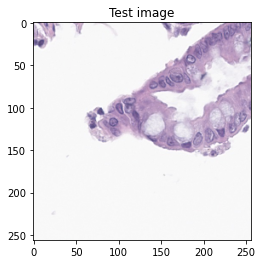

In [7]:
plt.imshow(tensor_image_to_numpy(dataset[0][0]))
plt.title("Test image")
plt.show()

## Creating cell detections with Mask R-CNN

Cyril trained this Mask R-CNN last summer (2022). It works pretty well on our dataset. It was trained on [CoNSeP](https://paperswithcode.com/dataset/consep).

In [6]:
import maskrcnn.model

model = maskrcnn.model.get_model(
    num_classes=6,
    path="/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/projects/spatial_omics/code/MaskRCNN/models/maskrcnn_resnet50_1_10.pt"
)

Write a data preprocessor, which standard-scales each image.

In [13]:
def standard_scaler(patch_or_patches: torch.Tensor):
    # patch.shape: ([B,] 3, H, W)
    # ([B,] 3, 1, 1)
    mean = patch_or_patches.mean(dim=(-2, -1), keepdim=True)
    std = patch_or_patches.std(dim=(-2, -1), keepdim=True)
    return (patch_or_patches - mean) / std

def render_boxes(image, inference):
    import matplotlib.patches as patches
    
    # Labels range from 1-6
    colors = [
        None,
        # Red, green, blue, orange, purple, cyan
        (1, 0, 0),
        (0, 1, 0),
        (0, 0, 1),
        (1, 0.5, 0),
        (1, 0, 1),
        (0, 1, 1),
    ]
    
    # Create figure and axes
    fig, ax = plt.subplots()
    
    ax.set_title("Inference")

    # Display the image
    ax.imshow(image)
    
    for box, label in zip(inference['boxes'], inference['labels']):
        box = box.cpu()
        label = label.cpu()
        x1, y1, x2, y2 = box
        width = x2 - x1
        height = y2 - y1
        # https://stackoverflow.com/questions/37435369/matplotlib-how-to-draw-a-rectangle-on-image
        # Create a Rectangle patch
        rect = patches.Rectangle((int(x1), int(y1)), np.ceil(width), np.ceil(height), linewidth=1, edgecolor=colors[label], facecolor='none')
        # Add the patch to the Axes
        ax.add_patch(rect)

    plt.show()

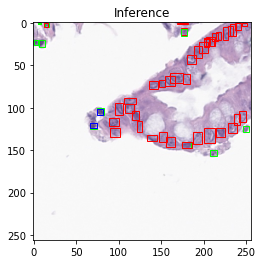

In [14]:
test_image, _test_image_labels = dataset[0]

model.eval()
with torch.no_grad():
    # Has keys 'boxes', 'labels', 'scores', and 'masks' (we will discard 'masks' in the future, though)
    inference = model([standard_scaler(test_image)])[0]

render_boxes(tensor_image_to_numpy(test_image), inference)

Looks good. Let's just run this on the whole dataset now.

In [19]:
# Create inferences for whole dataset

import tqdm

torch.cuda.empty_cache()
gc.collect()

# delete masks, too much memory
def inference_to_cpu(inference):
    cpu = {}
    for key in inference.keys():
        if type(inference[key]) == torch.Tensor:
            cpu[key] = inference[key].cpu()
        else:
            cpu[key] = inference[key]
    if 'masks' in cpu:
        del cpu['masks']
    return cpu

# This is a generator that returns the results in chunks. This is so we don't lose all progress if something goes wrong.
def infer_for_dataset(dataset):
    inferences = []
    
    model.eval()
    with torch.no_grad():
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=4)
        for batch in tqdm.tqdm(dataloader, desc="Inferring for slide"):
            images, labels = batch

            # Convert inference to CPU to save CUDA memory
            inferences.extend([inference_to_cpu(inference) for inference in model(list(images))])

            # Clear cache
            torch.cuda.empty_cache()
            gc.collect()

            # If we have done 128 batches, make a checkpoint
            if len(inferences) == 4 * 128:
                yield inferences
                inferences = []

    yield inferences

def run_and_save_predictions(subfolder, dataset):
    import os
    
    os.makedirs(subfolder)
    
    # Run and save predictions
    for i, inference_group in enumerate(infer_for_dataset(dataset)):
        torch.save(inference_group, f"{subfolder}/inferences_{i}.pt")
        print("Saved group", i, "with length", len(inference_group))

    # At the end, combine all the prediction chunks
    chunks = [torch.load(subfolder + '/' + file) for file in sorted(os.listdir(subfolder))]
    inferences = []
    for chunk in chunks:
        inferences.extend(chunk)
        
    torch.save(inferences, f"{subfolder}/combined.pt")

You can choose to infer everything again, on another dataset. But I won't, because I've already done it for this slide

In [10]:
already_inferred = True

if not already_inferred:
    run_and_save_predictions('cell-detections/autostainer_orig/run_0', dataset)
else:
    # These have already been non-maximum-suppressed.
    inferences = torch.load('cell-detections/autostainer_orig/combined_nms.pt')

Here are what a random sample of inferences looks like. There's a bit of overlap, so we'll do some non-maximum suppression.

Number of inferences: 4778
Samples displayed: [2732 2607 1653 3264 1033 4373 3468  705 2599 2135]


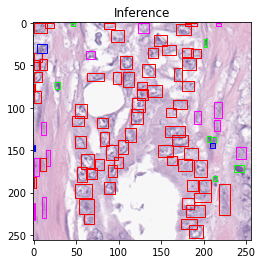

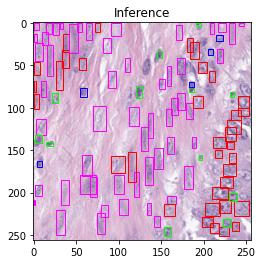

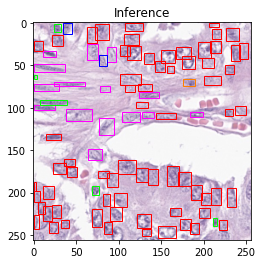

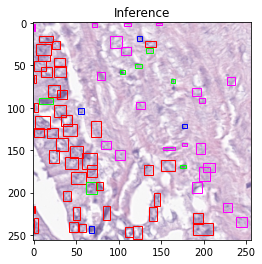

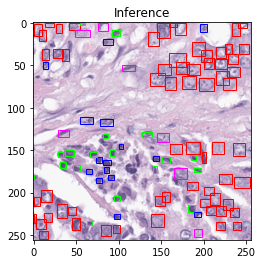

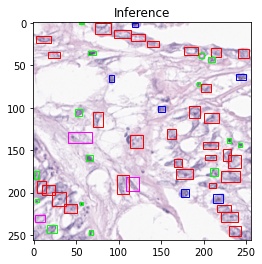

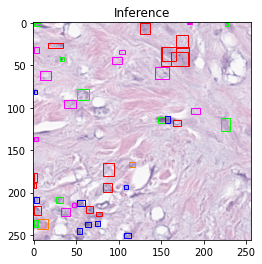

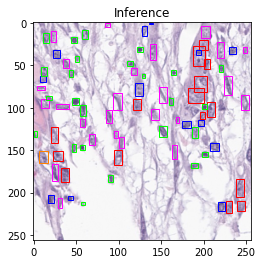

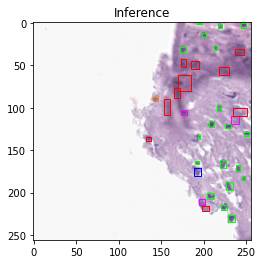

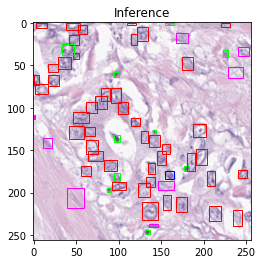

In [20]:
import numpy.random as nprandom

nprandom.seed(0)
nums = nprandom.randint(0, len(dataset), (10,))
print("Number of inferences:", len(inferences))
print("Samples displayed:", nums)
for num in nums:
    render_boxes(tensor_image_to_numpy(dataset[num][0]), inferences[num])

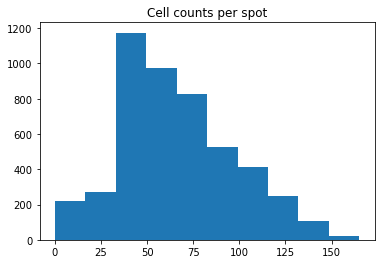

Total cell detections: 313640
Mean cells per spot: 65.6425282544998


In [17]:
# number of cells detected per square
cell_counts = [len(inference['boxes']) for inference in inferences]
plt.title("Cell counts per spot")
plt.hist(cell_counts)
plt.show()
print("Total cell detections:", sum(cell_counts))
print("Mean cells per spot:", sum(cell_counts) / len(inferences))

## Non-maximum suppression

Here, I look at each pair of boxes on a slide. If two boxes overlap sufficiently, the box with the lower score is deleted. I return the set of indexes that remain after non-maximum suppression.

In [23]:
def box_area(box):
    x1, y1, x2, y2 = box
    return abs((x2 - x1) * (y2 - y1))

def box_intersection(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])

    # compute the area of intersection rectangle
    interArea = abs(max((xB - xA, 0)) * max((yB - yA), 0))
    if interArea == 0:
        return 0
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(box_area(boxA) + box_area(boxB) - interArea)

    # return the intersection over union value
    return iou

def box_iou(box1, box2):
    start = time.time()
    intersection = box_intersection(box1, box2)
    union = box_area(box1) + box_area(box2) - intersection
    return intersection / union

# non maximum suppression - look for boxes with an IOU > 0.5, and keep the box with the higher score
def remaining_indexes_after_non_max_suppression(inferences, overlap_thres):
    boxes = inferences['boxes']
    scores = inferences['scores']
    rm = set()
    # For each box...
    for i in range(len(boxes)):
        if i in rm:
            continue
        for j in range(i+1,len(boxes)):
            if j in rm or j == i:
                continue
            iou = box_iou(boxes[i], boxes[j])
            if iou >= overlap_thres:
                if scores[i] > scores[j]:
                    rm.add(i)
                    break
                else:
                    rm.add(j)
                    continue
    return {i for i in range(len(boxes)) if i not in rm}


In [24]:
gc.collect()

0

Image 2607 seemed to have some overlaps, so let's test our algorithm on that.

Elapsed time: 2.352512836456299


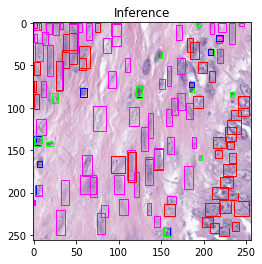

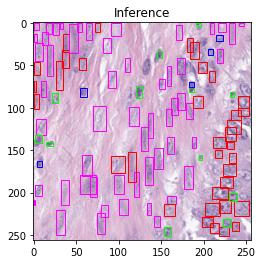

In [28]:
image = dataset[2607][0]
image_pil = tensor_image_to_numpy(image)

with torch.no_grad():
    inference_dirty = model([standard_scaler(image)])[0]


start = time.time()
# after
remaining_indexes = remaining_indexes_after_non_max_suppression(inference_dirty, 0.0005)

# Remove the defeated indexes.
new_inference = {}
for key in inference_dirty.keys():
    new_inference[key] = torch.stack([v for i, v in enumerate(inference_dirty[key]) if i in remaining_indexes])

elapsed_time = time.time() - start

print("Elapsed time:", elapsed_time)

render_boxes(image_pil, inference_dirty)
render_boxes(image_pil, new_inference)

# Result is much cleaner now!

Apply non-maximum suppression to a set of inferences. We should do this after inferring across any given slide for the first time.

In [30]:
def apply_nms_to_inferences():
    # apply nms
    new_inferences = []

    for inference in tqdm.tqdm(inferences, "running non-maximum suppression"):
        gc.collect()
        remaining_indexes = remaining_indexes_after_non_max_suppression(inference, 0.0005)
        new_inference = {}
        for key in inference.keys(): 
            new_inference[key] = [v for i, v in enumerate(inference[key]) if i in remaining_indexes]
        new_inferences.append(new_inference)

    # Save the new inferences
    torch.save(new_inferences, "cell-detections/autostainer_orig/combined_nms.pt")
    
    return new_inferences

In [19]:
def show_cell_counts(inferences):
    # number of cells detected per square
    cell_counts = [len(inference['boxes']) for inference in inferences]
    plt.title("Cell counts per spot")
    plt.hist(cell_counts)
    plt.show()
    print("Total cell detections:", sum(cell_counts))
    print("Mean cells per spot:", sum(cell_counts) / len(inferences))

## Training RNA inference model

Here, we load a slide, and we load the non-maximum-suppressed inferences.

In [22]:
import torchvision
import numpy as np

genes_to_use = list(np.load("filtered_set.npy"))
slide = Slide.load("input_data/preprocessed/autostainer_40x_cropped.pkl")
slide = slide.select_genes(genes_to_use).binary()

print(len(slide.genes))

features = len(slide.genes)

975


In [32]:
gc.collect()

0

In [25]:
import torchvision.transforms as T

In [26]:
dataset = PatchDataset(slide, 512, 1, device=torch.device('cuda'), patch_transform=standard_scaler)

In [61]:
import torch.nn.functional as F

def rotate90(x, y, k):
    if k == 0:
        return x, y
    return rotate90(-y, x, k - 1)

def rotate90_around(x, y, cx, cy, k):
    x2, y2 = rotate90(x - cx, y - cy, k)
    return x2 + cx, y2 + cy

def forward(image, boxes, apply_rotations=False):
    # get cell locations
    cell_locations = [
        (((box[0] + box[2]) / 2).item() * 2, ((box[1] + box[3]) / 2).item() * 2)
        for box in inference['boxes']
    ]
    box_size = 96
    rad = box_size // 2
    if apply_rotations:
        k = torch.randint(low=0, high=3, size=()).item()
        image = torch.rot90(image, k, dims=[-2, -1])
        cell_locations = [
            rotate90_around(cx, cy, 256, 256, k)
            for cx, cy in cell_locations
        ]
    # filter cell locations
    cell_locations = [
        (cx, cy)
        for cx, cy in cell_locations
        if 512 - rad > cx > rad and 512 - rad > cy > rad
    ]
    cell_images = torch.stack([
        image[:, int(cy) - rad:int(cy) + rad, int(cx) - rad:int(cx) + rad]
        for cx, cy in cell_locations
    ])
    cell_image_embeddings = model(cell_images)
    # distances: softmax(-r^2)
    distances = torch.tensor([((2-cx/64)**2 + (2-cy/64)**2) for cx, cy in cell_locations], device='cuda')
    distances = distances - distances.min()
    distances = torch.softmax(distances, dim=0)
    distances[distances < 1e-8] = 0
    # Instead of using distances, just use mean
#     cell_image_embeddings = cell_image_embeddings.T @ distances
    results = fc(cell_image_embeddings).T @ distances # .mean(dim=0)
    return results

In [ ]:
import tqdm

torch.manual_seed(0)

quadrants = slide.create_quadrants()

valid_quadrant, train_quadrant = quadrants[0]
valid_ds = PatchDataset(valid_quadrant, 512, 1, device=torch.device('cuda'), patch_transform=standard_scaler_per_channel)
train_ds = PatchDataset(train_quadrant, 512, 1, device=torch.device('cuda'), patch_transform=standard_scaler_per_channel)

In [34]:
# Focal loss and margin loss

def balanced_bce(logits, labels):
    pos = labels == 1
    neg = ~pos
    pos_logits = logits[pos]
    neg_logits = logits[neg]
    pos_labels = labels[pos]
    neg_labels = labels[neg]

    return 0.5 * (F.binary_cross_entropy_with_logits(pos_logits, pos_labels) + F.binary_cross_entropy_with_logits(neg_logits, neg_labels))

In [36]:
# Baseline model
baseline_model = torchvision.models.inception_v3('IMAGENET1K_V1').cuda()
baseline_model.aux_logits = False
baseline_model.fc = torch.nn.Linear(in_features=2048, out_features=features, bias=True).cuda()
baseline_model_optim = torch.optim.Adam(baseline_model.parameters())
baseline_model.train()

for epoch in range(2):
    with tqdm.tqdm(total=len(train_ds), desc='Training...') as pbar:
        i = 0
        running_loss = 0
        running_loss_baseline = 0
        dataloader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)
        transform = T.Compose([
            T.ColorJitter(),
            T.RandomRotation(90),
            T.RandomHorizontalFlip(),
            T.RandomVerticalFlip()
        ])
        for images, labels in dataloader:
            images = transform(images)
            preds = baseline_model(images)
            baseline_model_optim.zero_grad()
            loss = balanced_bce(preds, labels.float())
            loss.backward()
            baseline_model_optim.step()
            
            running_loss += loss.item() * len(images)
            i += len(images)
            
            pbar.update(len(images))
            pbar.set_postfix(loss=loss.item(), running_loss=running_loss/i)

torch.save(baseline_model.state_dict(), "baseline_model_inceptionv3.pt")

Training...: 100%|██████████| 3547/3547 [01:09<00:00, 50.85it/s, loss=0.404, running_loss=0.449]


In [64]:
# New model

in_quadrant = []
out_quadrant = []

mid_x = slide.spot_locations.image_x.median()
mid_y = slide.spot_locations.image_y.median()

for i in range(len(slide.spot_locations)):
    if slide.spot_locations.image_x[i] <= mid_x and slide.spot_locations.image_y[i] <= mid_y:
        in_quadrant.append(i)
    else:
        out_quadrant.append(i)

train_perm = torch.randperm(len(out_quadrant))

# can use strings for this
# https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html#torchvision.models.ResNet18_Weights
model = torchvision.models.resnet50('IMAGENET1K_V1').cuda()
model = model.train()
# replace FC layer
model.fc = torch.nn.Identity()
fc = torch.nn.Linear(in_features=2048, out_features=features, bias=True).cuda()
optim = torch.optim.Adam([*model.parameters(), *fc.parameters()])

batch_size = 32

for epoch in range(5):
    with tqdm.tqdm(total=len(train_perm), desc='Training...') as pbar:
        i = 0
        running_loss = 0
        running_loss_baseline = 0
        while i < len(train_perm):
            idxs = [out_quadrant[train_perm[j]] for j in range(i, min(i + batch_size, len(train_perm)))]
            optim.zero_grad()
            preds = []
            labels = []
            for idx in idxs:
                image, label = dataset[idx]
                # cell based model
                preds.append(forward(image, inferences[idx]['boxes'], apply_rotations=True))
                labels.append(label.float())
                
            loss = balanced_bce(torch.stack(preds), torch.stack(labels))
            loss.backward()
            optim.step() 
            running_loss += loss.item() * len(idxs)

            i += len(idxs)
            pbar.update(len(idxs))
            pbar.set_postfix(loss=loss.item(), running_loss=running_loss/i)

torch.save(model.state_dict(), "cell_model_resnet50.pt")

Training...: 100%|██████████| 3626/3626 [01:25<00:00, 42.19it/s, loss=0.579, running_loss=0.474]


In [42]:
def validate(pred_logits, spot_counts):            
    pred_logits = pred_logits.cpu()

    # tp = pred_tensor_bool == dataset.labels
    true_bool = spot_counts.bool()
    pred_scores = torch.sigmoid(pred_logits)
    pred_bool = pred_logits > 0

    tp = true_bool & pred_bool
    tn = ~(true_bool | pred_bool)
    fp = ~true_bool & pred_bool
    fn = true_bool & ~pred_bool

    acc = true_bool == pred_bool

    accuracy = acc.sum(axis=0) / true_bool.shape[0]
    plt.title("Histogram of accuracy")
    plt.hist(accuracy)
    plt.show()

    accuracy = tp.sum(axis=0) / true_bool.shape[0]
    plt.title("Histogram of TP")
    plt.hist(accuracy)
    plt.xlim(0, 1)
    plt.show()

    accuracy = tn.sum(axis=0) / true_bool.shape[0]
    plt.title("Histogram of TN")
    plt.hist(accuracy)
    plt.xlim(0, 1)
    plt.show()

    accuracy = fp.sum(axis=0) / true_bool.shape[0]
    plt.title("Histogram of FP")
    plt.hist(accuracy)
    plt.xlim(0, 1)
    plt.show()

    accuracy = fn.sum(axis=0) / true_bool.shape[0]
    plt.title("Histogram of FN")
    plt.xlim(0, 1)
    plt.hist(accuracy)
    plt.show()

    precision = tp.sum(axis=0) / (tp.sum(axis=0) + fp.sum(axis=0))
    plt.title("Histogram of Precision")
    plt.xlim(0, 1)
    plt.hist(precision)
    plt.show()

    recall = tp.sum(axis=0) / (tp.sum(axis=0) + fn.sum(axis=0))
    plt.title("Histogram of Recall")
    plt.xlim(0, 1)
    plt.hist(recall)
    plt.show()
    
    import sklearn
    
    auroc = sklearn.metrics.roc_auc_score(true_bool.numpy(), pred_scores.numpy(), average=None)
    plt.title("Histogram of AUROC")
    plt.xlim(0, 1)
    plt.hist(auroc)
    plt.show()

    print("Median precision:", precision.nanmedian())
    print("Median recall:", recall.median())
    print("Median AUROC:", np.nanmedian(auroc))

Validating...: 100%|██████████| 1231/1231 [00:10<00:00, 113.85it/s, loss=0.407, running_loss=0.542]


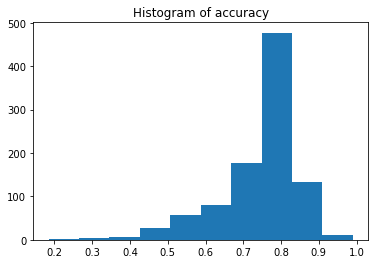

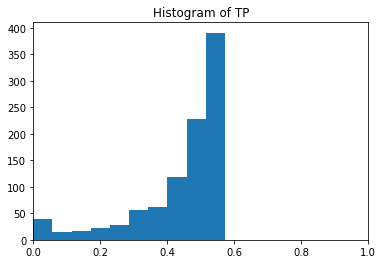

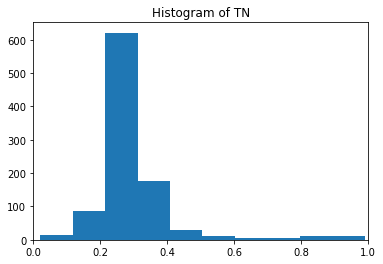

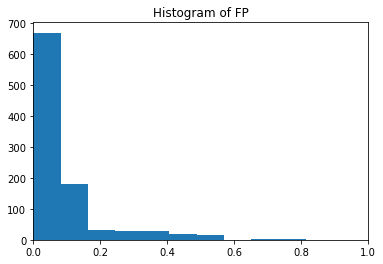

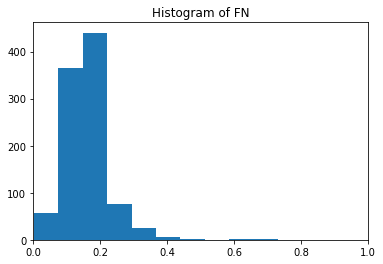

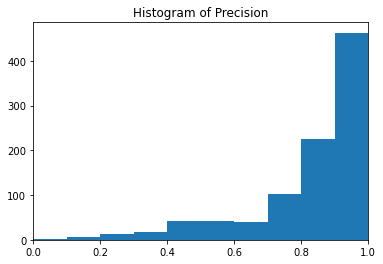

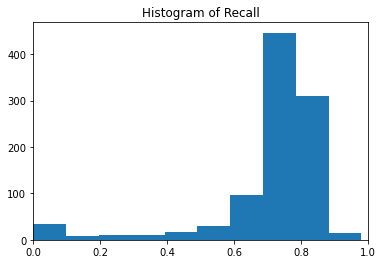

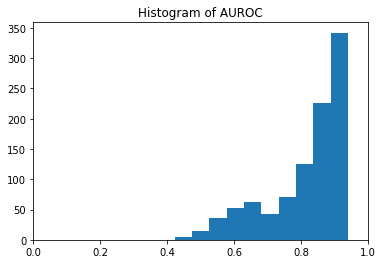

Median precision: tensor(0.8939)
Median recall: tensor(0.7603)
Median AUROC: 0.8595941891209413


In [43]:
baseline_predictions = []

# AEH groups
# Compare Spark-X and SpatialDE for autostainer vs. new slide?
# Raw statistical analysis: What genes are spatially variable on different slides?
# Also look at high AUC: what gene groups hit?
# Cells - RNA
# atac-seq
# histones are heavily implicated in cell state
# DNA methylation is also implicated in cell state
# how are transcription factors binding to DNA? epigenetic markers control how those key distinct units are being bound
# methylation prevents binding to the promoter region, and similarly, if the promoter region is tangled, you're not
# getting a lot of expression. histone methylation is actually different from DNA methylation
# while DNA methylation is one of the most important, others are important in different ways.
# another thing to think about is that there are ~20,000 genes, but there are a *lot* more proteins (more products)
# each of these different steps is a tool that allows for more fine-tuning of a product: whether it's methylation,
# accessibility, 3D confirmation, all of these things help enhance the tools that are there beyond what you see
# from normal gene expression. and then, proteins ultimately result in histology.

# in mice, you can delete certain genes and then look at the kinds of RNA that are produced. in the visium products,
# we look at the slides and see what happens at the periphery of a tumor in terms of immune invasion and etc. you normally
# can't do this with regular RNA-seq.

# if we can visualize that some pathway is expressed, then we can try to corroborate that with the protein staining.

# https://jackwestin.com/resources/mcat-content/control-of-gene-expression-in-eukaryotes/regulation-of-chromatin-structure

# much of this can be validated with the dataset that Lutz has been working on. we can look at the same image, see what markers
# we're predicting.

with tqdm.tqdm(total=len(valid_ds), desc='Validating...') as pbar:
    i = 0
    running_loss = 0
    running_loss_baseline = 0
    dataloader = torch.utils.data.DataLoader(valid_ds, batch_size=32, shuffle=False)
#     transform = T.Compose([
#         T.ColorJitter(),
#         T.RandomRotation(90),
#         T.RandomHorizontalFlip(),
#         T.RandomVerticalFlip()
#     ])
    for images, labels in dataloader:
#         images = transform(images)
        with torch.no_grad():
            preds = baseline_model(images)
            baseline_predictions.append(preds)
            loss = balanced_bce(preds, labels.float())

        running_loss += loss.item() * len(images)
        i += len(images)

        pbar.update(len(images))
        pbar.set_postfix(loss=loss.item(), running_loss=running_loss/i)
baseline_predictions = torch.cat(baseline_predictions, axis=0)
validate(baseline_predictions, valid_ds.slide.spot_counts)

Validating...:  94%|█████████▎| 1152/1231 [00:14<00:01, 77.55it/s, loss=0.628, running_loss=0.553]


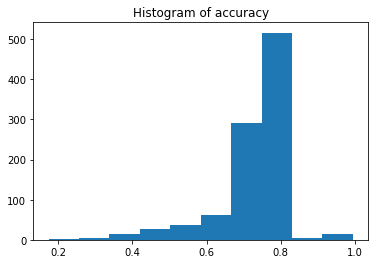

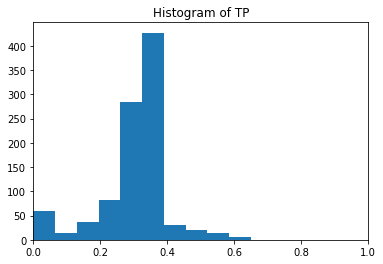

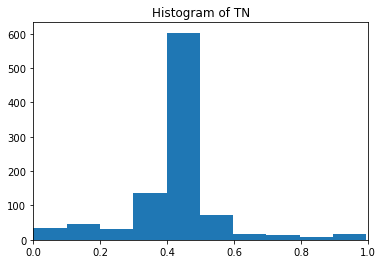

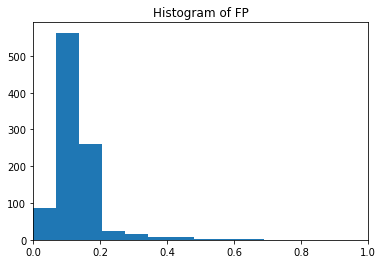

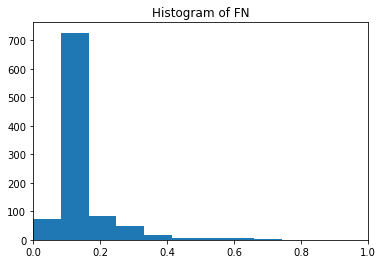

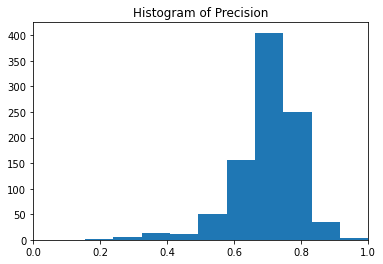

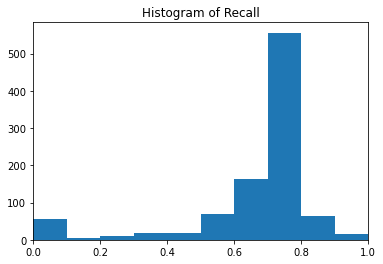

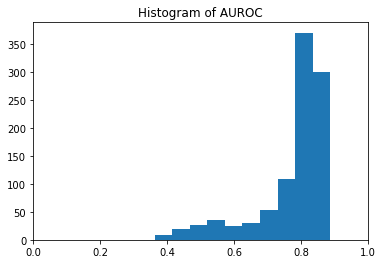

Median precision: tensor(0.7134)
Median recall: tensor(0.7327)
Median AUROC: 0.8147080446726275


In [70]:
predictions = []

model.train()

with tqdm.tqdm(total=len(valid_ds), desc='Validating...') as pbar:
    i = 0
    running_loss = 0
    running_loss_baseline = 0
    while i < len(in_quadrant):
        idxs = [in_quadrant[j] for j in range(i, min(i + batch_size, len(in_quadrant)))]
        with torch.no_grad():
            preds = []
            labels = []
            for idx in idxs:
                image, label = dataset[idx]
                # cell based model
                preds.append(forward(image, inferences[idx]['boxes']))
                labels.append(label.float())

            predictions.extend(preds)
            loss = balanced_bce(torch.stack(preds), torch.stack(labels))
        running_loss += loss.item() * len(idxs)

        i += len(idxs)
        pbar.update(len(idxs))
        pbar.set_postfix(loss=loss.item(), running_loss=running_loss/i)
validate(torch.stack(predictions), slide.spot_counts[in_quadrant])